In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.5


# Radial velocity fitting

In this tutorial, we will demonstrate how to fit radial velocity observations of an exoplanetary system using *exoplanet*.
We will follow [the getting started tutorial](https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html) from [the exellent RadVel package](https://radvel.readthedocs.io) where they fit for the parameters of the two planets in [the K2-24 system](https://arxiv.org/abs/1511.04497).

First, let's download the data from RadVel:

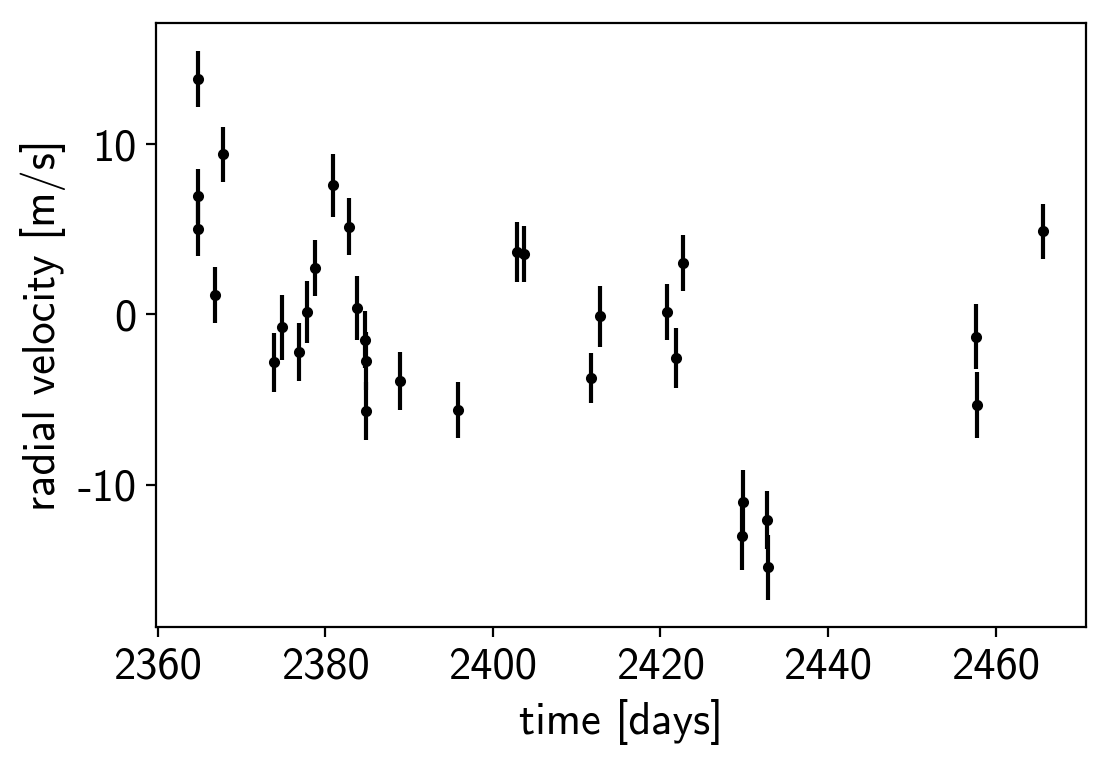

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

Now, we know the periods and transit times for the planets [from the K2 light curve](https://arxiv.org/abs/1511.04497), so let's start by using the :func:`exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [4]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3 (take a look at :ref:`intro-to-pymc3` if you're new to PyMC3).
First, we'll define our priors on the parameters:

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
        
    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    P = pm.Normal("P", mu=np.array(periods), sd=np.array(period_errs), shape=2)

    # Wide log-normal prior for semi-amplitude
    logK = pm.Normal("logK", mu=np.log(Ks), sd=10.0, shape=2)
    
    # This is a sanity check that restricts the semiamplitude to reasonable
    # values because things can get ugly as K -> 0
    pm.Potential("logK_bound", tt.switch(logK < 0, -np.inf, 0.0))
    
    # We also want to keep period physical but this probably won't be hit
    pm.Potential("P_bound", tt.switch(P <= 0, -np.inf, 0.0))

    # Eccentricity & argument of periasteron
    ecc = pm.Uniform("ecc", lower=0, upper=0.99, shape=2,
                     testval=np.array([0.1, 0.1]))
    omega = xo.distributions.Angle("omega", shape=2, testval=np.zeros(2))
    
    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

Now we'll define the orbit model:

In [6]:
with model:
    
    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=P, t0=t0,
        ecc=ecc, omega=omega)
    
    # Set up the RV model and save it as a deterministic
    # for plotting purposes later
    vrad = orbit.get_radial_velocity(x, K=tt.exp(logK))
    pm.Deterministic("vrad", vrad)
    
    # Define the background model
    A = np.vander(x - 0.5*(x.min() + x.max()), 3)
    bkg = pm.Deterministic("bkg", tt.dot(A, trend))
    
    # Sum over planets and add the background to get the full model
    rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)

For plotting purposes, it can be useful to also save the model on a fine grid in time.

In [7]:
t = np.linspace(x.min()-5, x.max()+5, 1000)

with model:
    vrad_pred = orbit.get_radial_velocity(t, K=tt.exp(logK))
    pm.Deterministic("vrad_pred", vrad_pred)
    A_pred = np.vander(t - 0.5*(x.min() + x.max()), 3)
    bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
    rv_model_pred = pm.Deterministic("rv_model_pred",
                                     tt.sum(vrad_pred, axis=-1) + bkg_pred)

Now, we can plot the initial model:

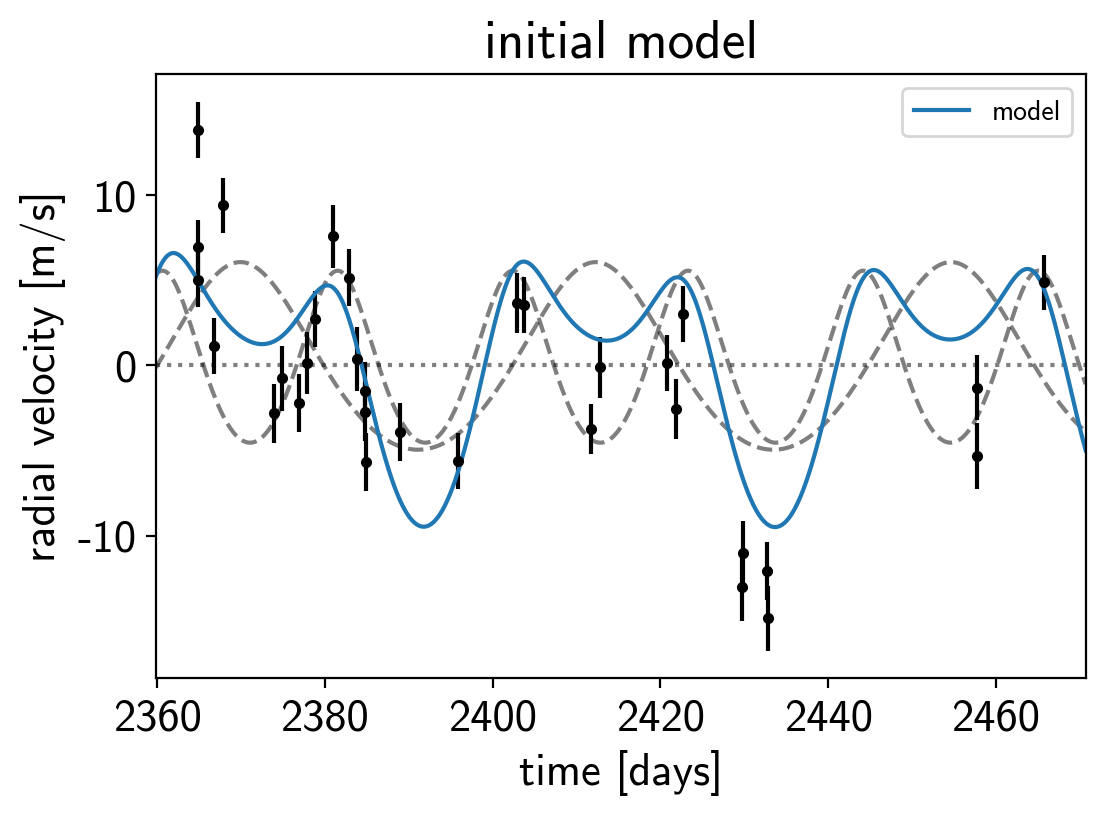

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, xo.eval_in_model(vrad_pred), "--k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(bkg_pred), ":k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("initial model");

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn't look amazing so let's add in the likelihood and fit for the maximum a posterior parameters.

In [9]:
with model:
    
    err = tt.sqrt(yerr**2 + tt.exp(2*logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)
    
    map_soln = xo.optimize(start=model.test_point, vars=[trend])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: -87.51672438985798 -> -72.63226415698486


optimizing logp for variables: ['trend', 'logs', 'omega_angle__', 'ecc_interval__', 'logK', 'P', 't0']


message: Desired error not necessarily achieved due to precision loss.
logp: -72.63226415698486 -> -22.056179633452878


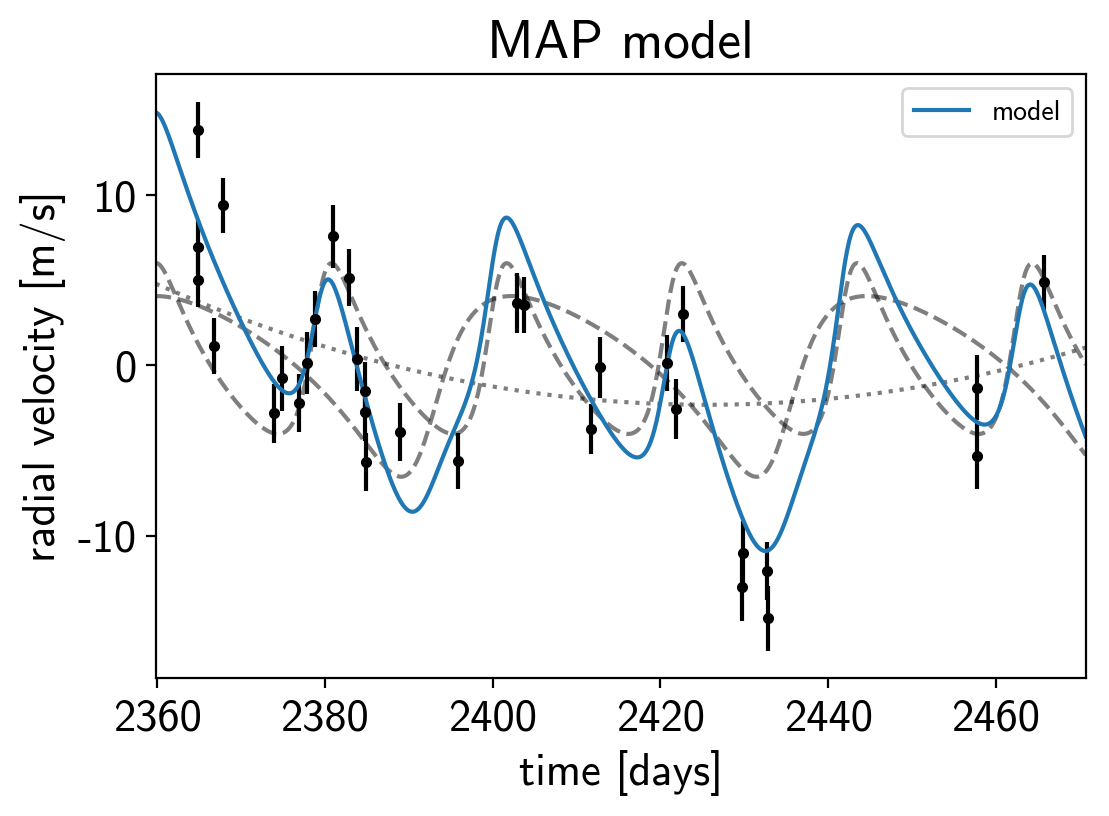

In [10]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("MAP model");

That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use a :class:`exoplanet.PyMC3Sampler` to tune the sampler (see the :ref:`pymc3-extras` tutorial for more information).

In [11]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with model:
    burnin = sampler.tune(tune=3000, start=model.test_point,
                          step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=3000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 20/808 [00:00<00:04, 196.93draws/s]

Sampling 4 chains:   3%|▎         | 28/808 [00:00<00:06, 123.34draws/s]

Sampling 4 chains:   4%|▍         | 36/808 [00:00<00:07, 103.54draws/s]

Sampling 4 chains:   5%|▌         | 44/808 [00:00<00:08, 93.21draws/s] 

Sampling 4 chains:   6%|▋         | 52/808 [00:00<00:08, 87.11draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:00<00:08, 83.20draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:00<00:09, 80.83draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:00<00:09, 79.12draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:00<00:09, 78.19draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:01<00:09, 76.89draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:01<00:09, 76.91draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:01<00:09, 76.89draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:01<00:09, 76.84draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:01<00:08, 76.83draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:01<00:08, 76.48draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:01<00:08, 75.87draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:01<00:08, 75.95draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:01<00:08, 77.02draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:02<00:08, 76.98draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [00:02<00:08, 76.92draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [00:02<00:08, 75.46draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:02<00:08, 75.96draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [00:02<00:08, 73.86draws/s]

Sampling 4 chains:  25%|██▌       | 204/808 [00:02<00:08, 74.83draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [00:02<00:07, 75.76draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [00:02<00:07, 76.50draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [00:02<00:07, 76.98draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [00:02<00:07, 77.28draws/s]

Sampling 4 chains:  30%|███       | 244/808 [00:03<00:07, 77.52draws/s]

Sampling 4 chains:  31%|███       | 252/808 [00:03<00:07, 77.58draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [00:03<00:07, 77.63draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:03<00:06, 77.76draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [00:03<00:06, 77.86draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [00:03<00:06, 77.90draws/s]

Sampling 4 chains:  36%|███▌      | 292/808 [00:03<00:06, 77.99draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [00:03<00:06, 77.94draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:03<00:06, 76.41draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [00:03<00:06, 76.70draws/s]

Sampling 4 chains:  40%|████      | 324/808 [00:04<00:06, 76.59draws/s]

Sampling 4 chains:  41%|████      | 332/808 [00:04<00:06, 76.52draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [00:04<00:06, 76.46draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [00:04<00:06, 76.44draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:04<00:05, 75.71draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [00:04<00:05, 75.93draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [00:04<00:05, 76.11draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [00:04<00:05, 76.27draws/s]

Sampling 4 chains:  48%|████▊     | 388/808 [00:04<00:05, 76.34draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [00:05<00:05, 76.18draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [00:05<00:05, 76.53draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [00:05<00:05, 76.72draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [00:05<00:05, 76.64draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [00:05<00:04, 76.53draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [00:05<00:04, 76.57draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [00:05<00:04, 76.55draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [00:05<00:04, 76.93draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [00:05<00:04, 77.27draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [00:05<00:04, 77.55draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [00:06<00:04, 77.26draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [00:06<00:04, 77.48draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [00:06<00:04, 77.72draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [00:06<00:04, 74.95draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [00:06<00:03, 75.49draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [00:06<00:03, 74.37draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [00:06<00:03, 74.97draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [00:06<00:03, 75.40draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [00:06<00:03, 75.71draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [00:07<00:03, 75.92draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [00:07<00:03, 76.07draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [00:07<00:03, 76.10draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [00:07<00:03, 75.23draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [00:07<00:03, 75.35draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [00:07<00:02, 75.44draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [00:07<00:02, 75.67draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [00:07<00:02, 75.92draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [00:07<00:02, 76.05draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [00:07<00:02, 76.22draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [00:08<00:02, 76.32draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [00:08<00:02, 76.37draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [00:08<00:02, 76.36draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [00:08<00:02, 76.74draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [00:08<00:01, 76.84draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [00:08<00:01, 76.75draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [00:08<00:01, 76.31draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [00:08<00:01, 76.23draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [00:08<00:01, 76.32draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [00:09<00:01, 76.36draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [00:09<00:01, 75.88draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [00:09<00:01, 76.08draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [00:09<00:01, 76.22draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [00:09<00:00, 76.34draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [00:09<00:00, 76.37draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [00:09<00:00, 76.40draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [00:09<00:00, 76.39draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [00:09<00:00, 76.55draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [00:09<00:00, 76.16draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:10<00:00, 75.97draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [00:10<00:00, 75.19draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [00:10<00:00, 67.62draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [00:10<00:00, 46.55draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:10<00:00, 74.18draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:02, 165.75draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:00<00:03, 122.66draws/s]

Sampling 4 chains:   9%|▉         | 37/408 [00:00<00:03, 103.82draws/s]

Sampling 4 chains:  11%|█         | 45/408 [00:00<00:03, 93.71draws/s] 

Sampling 4 chains:  13%|█▎        | 55/408 [00:00<00:03, 94.20draws/s]

Sampling 4 chains:  15%|█▌        | 63/408 [00:00<00:03, 88.09draws/s]

Sampling 4 chains:  18%|█▊        | 72/408 [00:00<00:03, 86.64draws/s]

Sampling 4 chains:  20%|█▉        | 81/408 [00:00<00:03, 86.49draws/s]

Sampling 4 chains:  22%|██▏       | 90/408 [00:00<00:03, 86.16draws/s]

Sampling 4 chains:  24%|██▍       | 99/408 [00:01<00:03, 84.54draws/s]

Sampling 4 chains:  26%|██▋       | 108/408 [00:01<00:03, 84.42draws/s]

Sampling 4 chains:  29%|██▉       | 118/408 [00:01<00:03, 86.82draws/s]

Sampling 4 chains:  31%|███       | 127/408 [00:01<00:03, 82.85draws/s]

Sampling 4 chains:  33%|███▎      | 136/408 [00:01<00:03, 81.59draws/s]

Sampling 4 chains:  36%|███▌      | 145/408 [00:01<00:03, 77.01draws/s]

Sampling 4 chains:  38%|███▊      | 155/408 [00:01<00:03, 80.71draws/s]

Sampling 4 chains:  40%|████      | 165/408 [00:01<00:02, 84.41draws/s]

Sampling 4 chains:  43%|████▎     | 174/408 [00:01<00:02, 84.67draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [00:02<00:02, 86.65draws/s]

Sampling 4 chains:  47%|████▋     | 193/408 [00:02<00:02, 85.73draws/s]

Sampling 4 chains:  50%|████▉     | 202/408 [00:02<00:02, 82.68draws/s]

Sampling 4 chains:  52%|█████▏    | 211/408 [00:02<00:02, 82.51draws/s]

Sampling 4 chains:  54%|█████▍    | 220/408 [00:02<00:02, 80.43draws/s]

Sampling 4 chains:  57%|█████▋    | 231/408 [00:02<00:02, 85.50draws/s]

Sampling 4 chains:  59%|█████▉    | 241/408 [00:02<00:01, 86.59draws/s]

Sampling 4 chains:  61%|██████▏   | 250/408 [00:02<00:02, 77.62draws/s]

Sampling 4 chains:  64%|██████▎   | 260/408 [00:03<00:01, 81.76draws/s]

Sampling 4 chains:  66%|██████▌   | 269/408 [00:03<00:01, 82.33draws/s]

Sampling 4 chains:  68%|██████▊   | 279/408 [00:03<00:01, 85.67draws/s]

Sampling 4 chains:  71%|███████   | 288/408 [00:03<00:01, 85.13draws/s]

Sampling 4 chains:  73%|███████▎  | 297/408 [00:03<00:01, 85.11draws/s]

Sampling 4 chains:  75%|███████▌  | 306/408 [00:03<00:01, 83.74draws/s]

Sampling 4 chains:  77%|███████▋  | 315/408 [00:03<00:01, 84.65draws/s]

Sampling 4 chains:  79%|███████▉  | 324/408 [00:03<00:01, 83.56draws/s]

Sampling 4 chains:  82%|████████▏ | 333/408 [00:03<00:00, 82.66draws/s]

Sampling 4 chains:  84%|████████▍ | 342/408 [00:03<00:00, 82.39draws/s]

Sampling 4 chains:  87%|████████▋ | 353/408 [00:04<00:00, 87.20draws/s]

Sampling 4 chains:  89%|████████▊ | 362/408 [00:04<00:00, 84.59draws/s]

Sampling 4 chains:  91%|█████████ | 371/408 [00:04<00:00, 81.99draws/s]

Sampling 4 chains:  93%|█████████▎| 380/408 [00:04<00:00, 83.14draws/s]

Sampling 4 chains:  95%|█████████▌| 389/408 [00:04<00:00, 82.68draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [00:04<00:00, 76.43draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [00:04<00:00, 52.51draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:05<00:00, 80.47draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 18/808 [00:00<00:05, 152.32draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:00<00:05, 148.76draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:00<00:05, 149.35draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:00<00:05, 127.36draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:00<00:05, 127.49draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:00<00:05, 133.90draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:00<00:05, 137.28draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:00<00:04, 152.86draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:01<00:04, 137.83draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:01<00:04, 148.21draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:01<00:03, 158.15draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:01<00:03, 158.88draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:01<00:03, 152.12draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:01<00:03, 170.15draws/s]

Sampling 4 chains:  33%|███▎      | 264/808 [00:01<00:03, 180.02draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [00:01<00:02, 178.02draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [00:01<00:02, 185.79draws/s]

Sampling 4 chains:  40%|████      | 324/808 [00:01<00:02, 187.54draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [00:02<00:02, 181.08draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [00:02<00:02, 183.09draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:02<00:02, 176.45draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [00:02<00:02, 181.82draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [00:02<00:02, 187.93draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [00:02<00:02, 179.31draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [00:02<00:01, 187.42draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [00:02<00:01, 186.46draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [00:02<00:01, 186.51draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [00:03<00:01, 186.31draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [00:03<00:01, 177.86draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [00:03<00:01, 173.83draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [00:03<00:01, 171.82draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [00:03<00:01, 167.51draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [00:03<00:01, 155.00draws/s]

Sampling 4 chains:  78%|███████▊  | 634/808 [00:03<00:01, 163.94draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [00:03<00:00, 184.65draws/s]

Sampling 4 chains:  85%|████████▍ | 686/808 [00:04<00:00, 178.23draws/s]

Sampling 4 chains:  88%|████████▊ | 710/808 [00:04<00:00, 191.56draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [00:04<00:00, 190.51draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [00:04<00:00, 168.24draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [00:04<00:00, 163.48draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [00:04<00:00, 166.96draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [00:04<00:00, 138.32draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:04<00:00, 167.87draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 40/1608 [00:00<00:03, 394.44draws/s]

Sampling 4 chains:   4%|▍         | 70/1608 [00:00<00:04, 357.64draws/s]

Sampling 4 chains:   8%|▊         | 134/1608 [00:00<00:03, 411.13draws/s]

Sampling 4 chains:  11%|█▏        | 183/1608 [00:00<00:03, 431.66draws/s]

Sampling 4 chains:  16%|█▌        | 253/1608 [00:00<00:02, 485.00draws/s]

Sampling 4 chains:  19%|█▉        | 304/1608 [00:00<00:02, 491.24draws/s]

Sampling 4 chains:  23%|██▎       | 371/1608 [00:00<00:02, 533.05draws/s]

Sampling 4 chains:  26%|██▋       | 425/1608 [00:00<00:02, 523.58draws/s]

Sampling 4 chains:  30%|███       | 485/1608 [00:00<00:02, 540.74draws/s]

Sampling 4 chains:  34%|███▍      | 548/1608 [00:01<00:01, 562.99draws/s]

Sampling 4 chains:  38%|███▊      | 606/1608 [00:01<00:01, 567.69draws/s]

Sampling 4 chains:  41%|████▏     | 665/1608 [00:01<00:01, 573.36draws/s]

Sampling 4 chains:  45%|████▌     | 726/1608 [00:01<00:01, 579.75draws/s]

Sampling 4 chains:  49%|████▉     | 785/1608 [00:01<00:01, 575.66draws/s]

Sampling 4 chains:  53%|█████▎    | 848/1608 [00:01<00:01, 589.46draws/s]

Sampling 4 chains:  56%|█████▋    | 908/1608 [00:01<00:01, 581.45draws/s]

Sampling 4 chains:  61%|██████    | 981/1608 [00:01<00:01, 618.74draws/s]

Sampling 4 chains:  65%|██████▍   | 1044/1608 [00:01<00:00, 604.49draws/s]

Sampling 4 chains:  69%|██████▉   | 1106/1608 [00:01<00:00, 597.03draws/s]

Sampling 4 chains:  73%|███████▎  | 1167/1608 [00:02<00:00, 564.34draws/s]

Sampling 4 chains:  76%|███████▌  | 1225/1608 [00:02<00:00, 561.35draws/s]

Sampling 4 chains:  80%|███████▉  | 1286/1608 [00:02<00:00, 574.09draws/s]

Sampling 4 chains:  84%|████████▎ | 1344/1608 [00:02<00:00, 561.55draws/s]

Sampling 4 chains:  87%|████████▋ | 1401/1608 [00:02<00:00, 470.69draws/s]

Sampling 4 chains:  90%|█████████ | 1451/1608 [00:02<00:00, 446.77draws/s]

Sampling 4 chains:  93%|█████████▎| 1498/1608 [00:03<00:00, 241.51draws/s]

Sampling 4 chains:  95%|█████████▌| 1535/1608 [00:03<00:00, 192.90draws/s]

Sampling 4 chains:  97%|█████████▋| 1565/1608 [00:03<00:00, 171.65draws/s]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [00:03<00:00, 171.26draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:03<00:00, 413.90draws/s]

Sampling 4 chains:   0%|          | 0/8408 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 54/8408 [00:00<00:15, 533.61draws/s]

Sampling 4 chains:   1%|          | 97/8408 [00:00<00:16, 495.44draws/s]

Sampling 4 chains:   2%|▏         | 146/8408 [00:00<00:16, 493.30draws/s]

Sampling 4 chains:   2%|▏         | 198/8408 [00:00<00:16, 497.42draws/s]

Sampling 4 chains:   3%|▎         | 263/8408 [00:00<00:15, 533.99draws/s]

Sampling 4 chains:   4%|▍         | 318/8408 [00:00<00:15, 535.66draws/s]

Sampling 4 chains:   4%|▍         | 373/8408 [00:00<00:14, 536.06draws/s]

Sampling 4 chains:   5%|▌         | 434/8408 [00:00<00:14, 553.88draws/s]

Sampling 4 chains:   6%|▌         | 502/8408 [00:00<00:13, 585.00draws/s]

Sampling 4 chains:   7%|▋         | 560/8408 [00:01<00:13, 577.65draws/s]

Sampling 4 chains:   7%|▋         | 617/8408 [00:01<00:13, 564.36draws/s]

Sampling 4 chains:   8%|▊         | 682/8408 [00:01<00:13, 586.24draws/s]

Sampling 4 chains:   9%|▉         | 741/8408 [00:01<00:13, 555.63draws/s]

Sampling 4 chains:   9%|▉         | 797/8408 [00:01<00:14, 531.01draws/s]

Sampling 4 chains:  10%|█         | 851/8408 [00:01<00:14, 533.37draws/s]

Sampling 4 chains:  11%|█         | 912/8408 [00:01<00:13, 551.82draws/s]

Sampling 4 chains:  12%|█▏        | 972/8408 [00:01<00:13, 563.75draws/s]

Sampling 4 chains:  12%|█▏        | 1029/8408 [00:01<00:13, 558.51draws/s]

Sampling 4 chains:  13%|█▎        | 1086/8408 [00:01<00:13, 539.76draws/s]

Sampling 4 chains:  14%|█▎        | 1151/8408 [00:02<00:12, 568.51draws/s]

Sampling 4 chains:  14%|█▍        | 1209/8408 [00:02<00:12, 558.82draws/s]

Sampling 4 chains:  15%|█▌        | 1266/8408 [00:02<00:13, 545.32draws/s]

Sampling 4 chains:  16%|█▌        | 1331/8408 [00:02<00:12, 571.60draws/s]

Sampling 4 chains:  17%|█▋        | 1401/8408 [00:02<00:11, 601.94draws/s]

Sampling 4 chains:  17%|█▋        | 1466/8408 [00:02<00:11, 615.00draws/s]

Sampling 4 chains:  18%|█▊        | 1529/8408 [00:02<00:11, 607.71draws/s]

Sampling 4 chains:  19%|█▉        | 1591/8408 [00:02<00:11, 584.51draws/s]

Sampling 4 chains:  20%|█▉        | 1650/8408 [00:02<00:12, 561.81draws/s]

Sampling 4 chains:  20%|██        | 1707/8408 [00:03<00:12, 530.05draws/s]

Sampling 4 chains:  21%|██        | 1761/8408 [00:03<00:13, 506.06draws/s]

Sampling 4 chains:  22%|██▏       | 1820/8408 [00:03<00:12, 527.38draws/s]

Sampling 4 chains:  22%|██▏       | 1874/8408 [00:03<00:12, 516.41draws/s]

Sampling 4 chains:  23%|██▎       | 1934/8408 [00:03<00:12, 537.41draws/s]

Sampling 4 chains:  24%|██▍       | 2011/8408 [00:03<00:10, 587.71draws/s]

Sampling 4 chains:  25%|██▍       | 2072/8408 [00:03<00:11, 575.75draws/s]

Sampling 4 chains:  25%|██▌       | 2132/8408 [00:03<00:10, 581.69draws/s]

Sampling 4 chains:  26%|██▌       | 2192/8408 [00:03<00:10, 568.95draws/s]

Sampling 4 chains:  27%|██▋       | 2252/8408 [00:04<00:10, 576.20draws/s]

Sampling 4 chains:  28%|██▊       | 2316/8408 [00:04<00:10, 593.27draws/s]

Sampling 4 chains:  28%|██▊       | 2382/8408 [00:04<00:09, 610.74draws/s]

Sampling 4 chains:  29%|██▉       | 2444/8408 [00:04<00:10, 584.67draws/s]

Sampling 4 chains:  30%|██▉       | 2504/8408 [00:04<00:10, 561.55draws/s]

Sampling 4 chains:  30%|███       | 2564/8408 [00:04<00:10, 571.93draws/s]

Sampling 4 chains:  31%|███       | 2625/8408 [00:04<00:09, 581.71draws/s]

Sampling 4 chains:  32%|███▏      | 2694/8408 [00:04<00:09, 609.06draws/s]

Sampling 4 chains:  33%|███▎      | 2764/8408 [00:04<00:08, 630.26draws/s]

Sampling 4 chains:  34%|███▎      | 2828/8408 [00:04<00:09, 599.31draws/s]

Sampling 4 chains:  34%|███▍      | 2889/8408 [00:05<00:09, 600.75draws/s]

Sampling 4 chains:  35%|███▌      | 2950/8408 [00:05<00:09, 590.89draws/s]

Sampling 4 chains:  36%|███▌      | 3010/8408 [00:05<00:09, 582.09draws/s]

Sampling 4 chains:  37%|███▋      | 3069/8408 [00:05<00:09, 549.66draws/s]

Sampling 4 chains:  37%|███▋      | 3125/8408 [00:05<00:09, 533.19draws/s]

Sampling 4 chains:  38%|███▊      | 3179/8408 [00:05<00:10, 515.74draws/s]

Sampling 4 chains:  38%|███▊      | 3232/8408 [00:05<00:11, 453.14draws/s]

Sampling 4 chains:  39%|███▉      | 3280/8408 [00:05<00:11, 436.42draws/s]

Sampling 4 chains:  40%|███▉      | 3327/8408 [00:06<00:11, 445.26draws/s]

Sampling 4 chains:  40%|████      | 3375/8408 [00:06<00:11, 453.12draws/s]

Sampling 4 chains:  41%|████      | 3422/8408 [00:06<00:11, 435.32draws/s]

Sampling 4 chains:  41%|████▏     | 3473/8408 [00:06<00:10, 453.33draws/s]

Sampling 4 chains:  42%|████▏     | 3519/8408 [00:06<00:10, 454.31draws/s]

Sampling 4 chains:  42%|████▏     | 3565/8408 [00:06<00:10, 448.14draws/s]

Sampling 4 chains:  43%|████▎     | 3611/8408 [00:06<00:10, 450.29draws/s]

Sampling 4 chains:  43%|████▎     | 3657/8408 [00:06<00:11, 429.95draws/s]

Sampling 4 chains:  44%|████▍     | 3705/8408 [00:06<00:10, 440.75draws/s]

Sampling 4 chains:  45%|████▍     | 3750/8408 [00:06<00:10, 424.69draws/s]

Sampling 4 chains:  45%|████▌     | 3800/8408 [00:07<00:10, 444.77draws/s]

Sampling 4 chains:  46%|████▌     | 3845/8408 [00:07<00:11, 413.92draws/s]

Sampling 4 chains:  46%|████▌     | 3888/8408 [00:07<00:11, 383.95draws/s]

Sampling 4 chains:  47%|████▋     | 3928/8408 [00:07<00:11, 381.90draws/s]

Sampling 4 chains:  47%|████▋     | 3967/8408 [00:07<00:11, 374.91draws/s]

Sampling 4 chains:  48%|████▊     | 4015/8408 [00:07<00:10, 400.77draws/s]

Sampling 4 chains:  48%|████▊     | 4071/8408 [00:07<00:09, 437.45draws/s]

Sampling 4 chains:  49%|████▉     | 4133/8408 [00:07<00:08, 479.83draws/s]

Sampling 4 chains:  50%|████▉     | 4200/8408 [00:07<00:08, 524.23draws/s]

Sampling 4 chains:  51%|█████     | 4265/8408 [00:08<00:07, 553.68draws/s]

Sampling 4 chains:  51%|█████▏    | 4323/8408 [00:08<00:07, 560.69draws/s]

Sampling 4 chains:  52%|█████▏    | 4382/8408 [00:08<00:07, 567.39draws/s]

Sampling 4 chains:  53%|█████▎    | 4442/8408 [00:08<00:06, 574.48draws/s]

Sampling 4 chains:  54%|█████▎    | 4508/8408 [00:08<00:06, 597.12draws/s]

Sampling 4 chains:  54%|█████▍    | 4569/8408 [00:08<00:06, 597.85draws/s]

Sampling 4 chains:  55%|█████▌    | 4631/8408 [00:08<00:06, 603.66draws/s]

Sampling 4 chains:  56%|█████▌    | 4698/8408 [00:08<00:05, 620.66draws/s]

Sampling 4 chains:  57%|█████▋    | 4763/8408 [00:08<00:05, 627.90draws/s]

Sampling 4 chains:  58%|█████▊    | 4835/8408 [00:08<00:05, 652.63draws/s]

Sampling 4 chains:  58%|█████▊    | 4904/8408 [00:09<00:05, 662.19draws/s]

Sampling 4 chains:  59%|█████▉    | 4971/8408 [00:09<00:05, 635.00draws/s]

Sampling 4 chains:  60%|█████▉    | 5035/8408 [00:09<00:05, 626.74draws/s]

Sampling 4 chains:  61%|██████    | 5099/8408 [00:09<00:05, 596.83draws/s]

Sampling 4 chains:  61%|██████▏   | 5160/8408 [00:09<00:05, 593.71draws/s]

Sampling 4 chains:  62%|██████▏   | 5227/8408 [00:09<00:05, 614.54draws/s]

Sampling 4 chains:  63%|██████▎   | 5301/8408 [00:09<00:04, 644.43draws/s]

Sampling 4 chains:  64%|██████▍   | 5379/8408 [00:09<00:04, 678.90draws/s]

Sampling 4 chains:  65%|██████▍   | 5452/8408 [00:09<00:04, 692.23draws/s]

Sampling 4 chains:  66%|██████▌   | 5522/8408 [00:10<00:04, 653.54draws/s]

Sampling 4 chains:  66%|██████▋   | 5589/8408 [00:10<00:04, 635.27draws/s]

Sampling 4 chains:  67%|██████▋   | 5654/8408 [00:10<00:04, 628.83draws/s]

Sampling 4 chains:  68%|██████▊   | 5718/8408 [00:10<00:04, 619.53draws/s]

Sampling 4 chains:  69%|██████▉   | 5781/8408 [00:10<00:04, 611.01draws/s]

Sampling 4 chains:  69%|██████▉   | 5843/8408 [00:10<00:04, 589.00draws/s]

Sampling 4 chains:  70%|███████   | 5903/8408 [00:10<00:04, 535.41draws/s]

Sampling 4 chains:  71%|███████   | 5958/8408 [00:10<00:04, 520.50draws/s]

Sampling 4 chains:  71%|███████▏  | 6011/8408 [00:10<00:04, 503.71draws/s]

Sampling 4 chains:  72%|███████▏  | 6063/8408 [00:11<00:04, 502.92draws/s]

Sampling 4 chains:  73%|███████▎  | 6118/8408 [00:11<00:04, 515.81draws/s]

Sampling 4 chains:  73%|███████▎  | 6171/8408 [00:11<00:04, 517.71draws/s]

Sampling 4 chains:  74%|███████▍  | 6224/8408 [00:11<00:04, 517.36draws/s]

Sampling 4 chains:  75%|███████▍  | 6284/8408 [00:11<00:03, 538.21draws/s]

Sampling 4 chains:  75%|███████▌  | 6348/8408 [00:11<00:03, 559.80draws/s]

Sampling 4 chains:  76%|███████▌  | 6406/8408 [00:11<00:03, 562.87draws/s]

Sampling 4 chains:  77%|███████▋  | 6467/8408 [00:11<00:03, 574.75draws/s]

Sampling 4 chains:  78%|███████▊  | 6536/8408 [00:11<00:03, 604.80draws/s]

Sampling 4 chains:  78%|███████▊  | 6598/8408 [00:11<00:02, 606.44draws/s]

Sampling 4 chains:  79%|███████▉  | 6666/8408 [00:12<00:02, 621.51draws/s]

Sampling 4 chains:  80%|████████  | 6729/8408 [00:12<00:02, 616.69draws/s]

Sampling 4 chains:  81%|████████  | 6798/8408 [00:12<00:02, 634.26draws/s]

Sampling 4 chains:  82%|████████▏ | 6866/8408 [00:12<00:02, 646.05draws/s]

Sampling 4 chains:  82%|████████▏ | 6934/8408 [00:12<00:02, 655.84draws/s]

Sampling 4 chains:  83%|████████▎ | 7000/8408 [00:12<00:02, 640.98draws/s]

Sampling 4 chains:  84%|████████▍ | 7065/8408 [00:12<00:02, 629.97draws/s]

Sampling 4 chains:  85%|████████▍ | 7129/8408 [00:12<00:02, 537.52draws/s]

Sampling 4 chains:  85%|████████▌ | 7186/8408 [00:12<00:02, 530.64draws/s]

Sampling 4 chains:  86%|████████▌ | 7241/8408 [00:13<00:02, 533.02draws/s]

Sampling 4 chains:  87%|████████▋ | 7297/8408 [00:13<00:02, 538.32draws/s]

Sampling 4 chains:  87%|████████▋ | 7352/8408 [00:13<00:02, 524.33draws/s]

Sampling 4 chains:  88%|████████▊ | 7414/8408 [00:13<00:01, 548.15draws/s]

Sampling 4 chains:  89%|████████▉ | 7470/8408 [00:13<00:01, 535.12draws/s]

Sampling 4 chains:  89%|████████▉ | 7525/8408 [00:13<00:01, 524.35draws/s]

Sampling 4 chains:  90%|█████████ | 7578/8408 [00:13<00:01, 503.01draws/s]

Sampling 4 chains:  91%|█████████ | 7629/8408 [00:13<00:01, 480.07draws/s]

Sampling 4 chains:  91%|█████████▏| 7678/8408 [00:13<00:01, 473.68draws/s]

Sampling 4 chains:  92%|█████████▏| 7726/8408 [00:14<00:01, 467.78draws/s]

Sampling 4 chains:  93%|█████████▎| 7778/8408 [00:14<00:01, 481.29draws/s]

Sampling 4 chains:  93%|█████████▎| 7830/8408 [00:14<00:01, 490.17draws/s]

Sampling 4 chains:  94%|█████████▎| 7880/8408 [00:14<00:01, 484.45draws/s]

Sampling 4 chains:  94%|█████████▍| 7935/8408 [00:14<00:00, 500.16draws/s]

Sampling 4 chains:  95%|█████████▌| 7995/8408 [00:14<00:00, 524.81draws/s]

Sampling 4 chains:  96%|█████████▌| 8048/8408 [00:14<00:00, 500.25draws/s]

Sampling 4 chains:  96%|█████████▋| 8099/8408 [00:14<00:00, 457.52draws/s]

Sampling 4 chains:  97%|█████████▋| 8155/8408 [00:14<00:00, 483.47draws/s]

Sampling 4 chains:  98%|█████████▊| 8209/8408 [00:14<00:00, 497.40draws/s]

Sampling 4 chains:  98%|█████████▊| 8268/8408 [00:15<00:00, 521.83draws/s]

Sampling 4 chains:  99%|█████████▉| 8322/8408 [00:15<00:00, 444.37draws/s]

Sampling 4 chains: 100%|█████████▉| 8370/8408 [00:15<00:00, 349.11draws/s]

Sampling 4 chains: 100%|██████████| 8408/8408 [00:15<00:00, 534.00draws/s]

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 36/1208 [00:00<00:03, 344.10draws/s]

Sampling 4 chains:   5%|▌         | 65/1208 [00:00<00:03, 325.11draws/s]

Sampling 4 chains:   9%|▉         | 110/1208 [00:00<00:03, 354.26draws/s]

Sampling 4 chains:  13%|█▎        | 159/1208 [00:00<00:02, 384.79draws/s]

Sampling 4 chains:  18%|█▊        | 212/1208 [00:00<00:02, 418.95draws/s]

Sampling 4 chains:  22%|██▏       | 268/1208 [00:00<00:02, 451.62draws/s]

Sampling 4 chains:  26%|██▋       | 318/1208 [00:00<00:01, 462.78draws/s]

Sampling 4 chains:  30%|███       | 366/1208 [00:00<00:01, 466.17draws/s]

Sampling 4 chains:  35%|███▌      | 428/1208 [00:00<00:01, 499.31draws/s]

Sampling 4 chains:  40%|████      | 487/1208 [00:01<00:01, 522.92draws/s]

Sampling 4 chains:  45%|████▍     | 540/1208 [00:01<00:01, 507.85draws/s]

Sampling 4 chains:  50%|████▉     | 603/1208 [00:01<00:01, 537.04draws/s]

Sampling 4 chains:  56%|█████▋    | 682/1208 [00:01<00:00, 593.71draws/s]

Sampling 4 chains:  62%|██████▏   | 744/1208 [00:01<00:00, 575.45draws/s]

Sampling 4 chains:  67%|██████▋   | 805/1208 [00:01<00:00, 584.92draws/s]

Sampling 4 chains:  72%|███████▏  | 865/1208 [00:01<00:00, 561.57draws/s]

Sampling 4 chains:  76%|███████▋  | 923/1208 [00:01<00:00, 511.55draws/s]

Sampling 4 chains:  81%|████████  | 976/1208 [00:01<00:00, 514.29draws/s]

Sampling 4 chains:  85%|████████▌ | 1030/1208 [00:02<00:00, 521.37draws/s]

Sampling 4 chains:  90%|████████▉ | 1083/1208 [00:02<00:00, 436.93draws/s]

Sampling 4 chains:  94%|█████████▎| 1130/1208 [00:02<00:00, 392.14draws/s]

Sampling 4 chains:  97%|█████████▋| 1173/1208 [00:02<00:00, 304.44draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [00:02<00:00, 443.56draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [trend, logs, omega, ecc, logK, P, t0]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 55/12000 [00:00<00:21, 545.79draws/s]

Sampling 4 chains:   1%|          | 127/12000 [00:00<00:20, 587.77draws/s]

Sampling 4 chains:   2%|▏         | 205/12000 [00:00<00:18, 633.48draws/s]

Sampling 4 chains:   2%|▏         | 288/12000 [00:00<00:17, 679.95draws/s]

Sampling 4 chains:   3%|▎         | 374/12000 [00:00<00:16, 725.02draws/s]

Sampling 4 chains:   4%|▍         | 458/12000 [00:00<00:15, 755.35draws/s]

Sampling 4 chains:   4%|▍         | 533/12000 [00:00<00:15, 752.71draws/s]

Sampling 4 chains:   5%|▌         | 617/12000 [00:00<00:14, 776.52draws/s]

Sampling 4 chains:   6%|▌         | 693/12000 [00:00<00:14, 756.60draws/s]

Sampling 4 chains:   6%|▋         | 771/12000 [00:01<00:14, 761.27draws/s]

Sampling 4 chains:   7%|▋         | 847/12000 [00:01<00:14, 758.10draws/s]

Sampling 4 chains:   8%|▊         | 923/12000 [00:01<00:14, 749.73draws/s]

Sampling 4 chains:   8%|▊         | 1001/12000 [00:01<00:14, 758.23draws/s]

Sampling 4 chains:   9%|▉         | 1077/12000 [00:01<00:14, 756.54draws/s]

Sampling 4 chains:  10%|▉         | 1153/12000 [00:01<00:14, 756.75draws/s]

Sampling 4 chains:  10%|█         | 1232/12000 [00:01<00:14, 763.55draws/s]

Sampling 4 chains:  11%|█         | 1309/12000 [00:01<00:14, 759.62draws/s]

Sampling 4 chains:  12%|█▏        | 1385/12000 [00:01<00:14, 745.77draws/s]

Sampling 4 chains:  12%|█▏        | 1460/12000 [00:01<00:14, 745.61draws/s]

Sampling 4 chains:  13%|█▎        | 1547/12000 [00:02<00:13, 778.66draws/s]

Sampling 4 chains:  14%|█▎        | 1627/12000 [00:02<00:13, 781.63draws/s]

Sampling 4 chains:  14%|█▍        | 1709/12000 [00:02<00:13, 790.22draws/s]

Sampling 4 chains:  15%|█▍        | 1789/12000 [00:02<00:13, 774.06draws/s]

Sampling 4 chains:  16%|█▌        | 1867/12000 [00:02<00:13, 746.01draws/s]

Sampling 4 chains:  16%|█▌        | 1942/12000 [00:02<00:13, 735.05draws/s]

Sampling 4 chains:  17%|█▋        | 2016/12000 [00:02<00:13, 725.21draws/s]

Sampling 4 chains:  18%|█▊        | 2106/12000 [00:02<00:12, 765.05draws/s]

Sampling 4 chains:  18%|█▊        | 2186/12000 [00:02<00:12, 771.50draws/s]

Sampling 4 chains:  19%|█▉        | 2268/12000 [00:02<00:12, 784.86draws/s]

Sampling 4 chains:  20%|█▉        | 2347/12000 [00:03<00:12, 775.43draws/s]

Sampling 4 chains:  20%|██        | 2431/12000 [00:03<00:12, 789.71draws/s]

Sampling 4 chains:  21%|██        | 2514/12000 [00:03<00:11, 799.26draws/s]

Sampling 4 chains:  22%|██▏       | 2595/12000 [00:03<00:12, 779.40draws/s]

Sampling 4 chains:  22%|██▏       | 2676/12000 [00:03<00:11, 785.61draws/s]

Sampling 4 chains:  23%|██▎       | 2755/12000 [00:03<00:12, 752.06draws/s]

Sampling 4 chains:  24%|██▎       | 2834/12000 [00:03<00:12, 762.52draws/s]

Sampling 4 chains:  24%|██▍       | 2911/12000 [00:03<00:12, 745.78draws/s]

Sampling 4 chains:  25%|██▍       | 2986/12000 [00:03<00:12, 740.36draws/s]

Sampling 4 chains:  26%|██▌       | 3068/12000 [00:04<00:11, 761.40draws/s]

Sampling 4 chains:  26%|██▌       | 3145/12000 [00:04<00:11, 753.10draws/s]

Sampling 4 chains:  27%|██▋       | 3221/12000 [00:04<00:11, 741.58draws/s]

Sampling 4 chains:  28%|██▊       | 3301/12000 [00:04<00:11, 757.61draws/s]

Sampling 4 chains:  28%|██▊       | 3389/12000 [00:04<00:10, 787.66draws/s]

Sampling 4 chains:  29%|██▉       | 3473/12000 [00:04<00:10, 801.90draws/s]

Sampling 4 chains:  30%|██▉       | 3554/12000 [00:04<00:10, 790.19draws/s]

Sampling 4 chains:  30%|███       | 3634/12000 [00:04<00:10, 767.76draws/s]

Sampling 4 chains:  31%|███       | 3716/12000 [00:04<00:10, 781.73draws/s]

Sampling 4 chains:  32%|███▏      | 3796/12000 [00:04<00:10, 785.63draws/s]

Sampling 4 chains:  32%|███▏      | 3889/12000 [00:05<00:09, 822.60draws/s]

Sampling 4 chains:  33%|███▎      | 3972/12000 [00:05<00:10, 800.31draws/s]

Sampling 4 chains:  34%|███▍      | 4071/12000 [00:05<00:09, 847.95draws/s]

Sampling 4 chains:  35%|███▍      | 4162/12000 [00:05<00:09, 864.02draws/s]

Sampling 4 chains:  35%|███▌      | 4250/12000 [00:05<00:09, 827.01draws/s]

Sampling 4 chains:  36%|███▌      | 4334/12000 [00:05<00:09, 780.17draws/s]

Sampling 4 chains:  37%|███▋      | 4414/12000 [00:05<00:10, 749.28draws/s]

Sampling 4 chains:  37%|███▋      | 4497/12000 [00:05<00:09, 769.78draws/s]

Sampling 4 chains:  38%|███▊      | 4576/12000 [00:05<00:09, 772.55draws/s]

Sampling 4 chains:  39%|███▉      | 4654/12000 [00:06<00:09, 754.16draws/s]

Sampling 4 chains:  39%|███▉      | 4730/12000 [00:06<00:09, 730.08draws/s]

Sampling 4 chains:  40%|████      | 4807/12000 [00:06<00:09, 740.92draws/s]

Sampling 4 chains:  41%|████      | 4882/12000 [00:06<00:09, 742.64draws/s]

Sampling 4 chains:  41%|████▏     | 4957/12000 [00:06<00:09, 728.68draws/s]

Sampling 4 chains:  42%|████▏     | 5033/12000 [00:06<00:09, 736.84draws/s]

Sampling 4 chains:  43%|████▎     | 5120/12000 [00:06<00:08, 772.23draws/s]

Sampling 4 chains:  43%|████▎     | 5198/12000 [00:06<00:09, 740.84draws/s]

Sampling 4 chains:  44%|████▍     | 5273/12000 [00:06<00:09, 727.79draws/s]

Sampling 4 chains:  45%|████▍     | 5361/12000 [00:06<00:08, 766.50draws/s]

Sampling 4 chains:  45%|████▌     | 5439/12000 [00:07<00:08, 751.42draws/s]

Sampling 4 chains:  46%|████▌     | 5516/12000 [00:07<00:08, 754.18draws/s]

Sampling 4 chains:  47%|████▋     | 5592/12000 [00:07<00:08, 751.70draws/s]

Sampling 4 chains:  47%|████▋     | 5668/12000 [00:07<00:08, 720.68draws/s]

Sampling 4 chains:  48%|████▊     | 5744/12000 [00:07<00:08, 731.65draws/s]

Sampling 4 chains:  48%|████▊     | 5818/12000 [00:07<00:08, 721.67draws/s]

Sampling 4 chains:  49%|████▉     | 5891/12000 [00:07<00:08, 720.20draws/s]

Sampling 4 chains:  50%|████▉     | 5964/12000 [00:07<00:08, 710.61draws/s]

Sampling 4 chains:  50%|█████     | 6036/12000 [00:07<00:08, 703.92draws/s]

Sampling 4 chains:  51%|█████     | 6107/12000 [00:08<00:08, 693.18draws/s]

Sampling 4 chains:  52%|█████▏    | 6187/12000 [00:08<00:08, 722.08draws/s]

Sampling 4 chains:  52%|█████▏    | 6261/12000 [00:08<00:07, 725.70draws/s]

Sampling 4 chains:  53%|█████▎    | 6337/12000 [00:08<00:07, 733.46draws/s]

Sampling 4 chains:  53%|█████▎    | 6414/12000 [00:08<00:07, 742.86draws/s]

Sampling 4 chains:  54%|█████▍    | 6496/12000 [00:08<00:07, 761.73draws/s]

Sampling 4 chains:  55%|█████▍    | 6573/12000 [00:08<00:07, 762.57draws/s]

Sampling 4 chains:  55%|█████▌    | 6650/12000 [00:08<00:07, 761.42draws/s]

Sampling 4 chains:  56%|█████▌    | 6737/12000 [00:08<00:06, 788.96draws/s]

Sampling 4 chains:  57%|█████▋    | 6817/12000 [00:08<00:06, 773.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6897/12000 [00:09<00:06, 780.41draws/s]

Sampling 4 chains:  58%|█████▊    | 6976/12000 [00:09<00:06, 759.13draws/s]

Sampling 4 chains:  59%|█████▉    | 7054/12000 [00:09<00:06, 764.15draws/s]

Sampling 4 chains:  59%|█████▉    | 7131/12000 [00:09<00:06, 726.50draws/s]

Sampling 4 chains:  60%|██████    | 7208/12000 [00:09<00:06, 736.11draws/s]

Sampling 4 chains:  61%|██████    | 7283/12000 [00:09<00:06, 724.76draws/s]

Sampling 4 chains:  61%|██████▏   | 7357/12000 [00:09<00:06, 729.11draws/s]

Sampling 4 chains:  62%|██████▏   | 7435/12000 [00:09<00:06, 742.55draws/s]

Sampling 4 chains:  63%|██████▎   | 7510/12000 [00:09<00:06, 741.67draws/s]

Sampling 4 chains:  63%|██████▎   | 7602/12000 [00:09<00:05, 786.71draws/s]

Sampling 4 chains:  64%|██████▍   | 7682/12000 [00:10<00:05, 755.45draws/s]

Sampling 4 chains:  65%|██████▍   | 7759/12000 [00:10<00:05, 756.08draws/s]

Sampling 4 chains:  65%|██████▌   | 7838/12000 [00:10<00:05, 764.88draws/s]

Sampling 4 chains:  66%|██████▌   | 7915/12000 [00:10<00:05, 765.86draws/s]

Sampling 4 chains:  67%|██████▋   | 7992/12000 [00:10<00:05, 757.71draws/s]

Sampling 4 chains:  67%|██████▋   | 8070/12000 [00:10<00:05, 764.16draws/s]

Sampling 4 chains:  68%|██████▊   | 8155/12000 [00:10<00:04, 785.09draws/s]

Sampling 4 chains:  69%|██████▊   | 8234/12000 [00:10<00:04, 769.85draws/s]

Sampling 4 chains:  69%|██████▉   | 8313/12000 [00:10<00:04, 773.24draws/s]

Sampling 4 chains:  70%|██████▉   | 8391/12000 [00:11<00:04, 758.23draws/s]

Sampling 4 chains:  71%|███████   | 8471/12000 [00:11<00:04, 768.34draws/s]

Sampling 4 chains:  71%|███████▏  | 8555/12000 [00:11<00:04, 787.23draws/s]

Sampling 4 chains:  72%|███████▏  | 8634/12000 [00:11<00:04, 786.61draws/s]

Sampling 4 chains:  73%|███████▎  | 8719/12000 [00:11<00:04, 802.71draws/s]

Sampling 4 chains:  73%|███████▎  | 8800/12000 [00:11<00:04, 780.91draws/s]

Sampling 4 chains:  74%|███████▍  | 8879/12000 [00:11<00:04, 750.66draws/s]

Sampling 4 chains:  75%|███████▍  | 8957/12000 [00:11<00:04, 756.94draws/s]

Sampling 4 chains:  75%|███████▌  | 9039/12000 [00:11<00:03, 773.63draws/s]

Sampling 4 chains:  76%|███████▌  | 9119/12000 [00:11<00:03, 779.85draws/s]

Sampling 4 chains:  77%|███████▋  | 9198/12000 [00:12<00:03, 776.13draws/s]

Sampling 4 chains:  77%|███████▋  | 9276/12000 [00:12<00:03, 755.01draws/s]

Sampling 4 chains:  78%|███████▊  | 9354/12000 [00:12<00:03, 761.66draws/s]

Sampling 4 chains:  79%|███████▊  | 9431/12000 [00:12<00:03, 760.81draws/s]

Sampling 4 chains:  79%|███████▉  | 9508/12000 [00:12<00:03, 755.86draws/s]

Sampling 4 chains:  80%|███████▉  | 9584/12000 [00:12<00:03, 747.16draws/s]

Sampling 4 chains:  81%|████████  | 9671/12000 [00:12<00:02, 779.30draws/s]

Sampling 4 chains:  81%|████████▏ | 9750/12000 [00:12<00:03, 726.95draws/s]

Sampling 4 chains:  82%|████████▏ | 9824/12000 [00:12<00:03, 705.42draws/s]

Sampling 4 chains:  82%|████████▏ | 9896/12000 [00:13<00:03, 691.45draws/s]

Sampling 4 chains:  83%|████████▎ | 9966/12000 [00:13<00:03, 675.70draws/s]

Sampling 4 chains:  84%|████████▎ | 10035/12000 [00:13<00:02, 677.26draws/s]

Sampling 4 chains:  84%|████████▍ | 10104/12000 [00:13<00:02, 658.38draws/s]

Sampling 4 chains:  85%|████████▍ | 10171/12000 [00:13<00:03, 547.41draws/s]

Sampling 4 chains:  85%|████████▌ | 10230/12000 [00:13<00:03, 519.56draws/s]

Sampling 4 chains:  86%|████████▌ | 10285/12000 [00:13<00:03, 503.62draws/s]

Sampling 4 chains:  86%|████████▌ | 10338/12000 [00:13<00:03, 508.65draws/s]

Sampling 4 chains:  87%|████████▋ | 10391/12000 [00:13<00:03, 503.32draws/s]

Sampling 4 chains:  87%|████████▋ | 10443/12000 [00:14<00:03, 496.06draws/s]

Sampling 4 chains:  87%|████████▋ | 10494/12000 [00:14<00:03, 470.23draws/s]

Sampling 4 chains:  88%|████████▊ | 10542/12000 [00:14<00:03, 471.01draws/s]

Sampling 4 chains:  88%|████████▊ | 10593/12000 [00:14<00:02, 481.28draws/s]

Sampling 4 chains:  89%|████████▊ | 10642/12000 [00:14<00:02, 477.26draws/s]

Sampling 4 chains:  89%|████████▉ | 10691/12000 [00:14<00:02, 477.47draws/s]

Sampling 4 chains:  89%|████████▉ | 10739/12000 [00:14<00:02, 476.72draws/s]

Sampling 4 chains:  90%|████████▉ | 10792/12000 [00:14<00:02, 488.93draws/s]

Sampling 4 chains:  90%|█████████ | 10844/12000 [00:14<00:02, 496.69draws/s]

Sampling 4 chains:  91%|█████████ | 10894/12000 [00:15<00:02, 497.44draws/s]

Sampling 4 chains:  91%|█████████ | 10947/12000 [00:15<00:02, 505.59draws/s]

Sampling 4 chains:  92%|█████████▏| 10998/12000 [00:15<00:01, 502.65draws/s]

Sampling 4 chains:  92%|█████████▏| 11049/12000 [00:15<00:01, 504.16draws/s]

Sampling 4 chains:  92%|█████████▎| 11100/12000 [00:15<00:01, 498.26draws/s]

Sampling 4 chains:  93%|█████████▎| 11150/12000 [00:15<00:01, 489.17draws/s]

Sampling 4 chains:  93%|█████████▎| 11199/12000 [00:15<00:01, 486.65draws/s]

Sampling 4 chains:  94%|█████████▍| 11251/12000 [00:15<00:01, 494.04draws/s]

Sampling 4 chains:  94%|█████████▍| 11301/12000 [00:15<00:01, 494.42draws/s]

Sampling 4 chains:  95%|█████████▍| 11351/12000 [00:15<00:01, 493.41draws/s]

Sampling 4 chains:  95%|█████████▌| 11401/12000 [00:16<00:01, 369.73draws/s]

Sampling 4 chains:  95%|█████████▌| 11443/12000 [00:16<00:01, 323.77draws/s]

Sampling 4 chains:  96%|█████████▌| 11480/12000 [00:16<00:01, 302.03draws/s]

Sampling 4 chains:  96%|█████████▌| 11514/12000 [00:16<00:01, 292.38draws/s]

Sampling 4 chains:  96%|█████████▌| 11546/12000 [00:16<00:01, 280.09draws/s]

Sampling 4 chains:  96%|█████████▋| 11576/12000 [00:16<00:01, 274.30draws/s]

Sampling 4 chains:  97%|█████████▋| 11605/12000 [00:16<00:01, 263.24draws/s]

Sampling 4 chains:  97%|█████████▋| 11633/12000 [00:17<00:01, 263.04draws/s]

Sampling 4 chains:  97%|█████████▋| 11661/12000 [00:17<00:01, 265.38draws/s]

Sampling 4 chains:  97%|█████████▋| 11689/12000 [00:17<00:01, 243.01draws/s]

Sampling 4 chains:  98%|█████████▊| 11715/12000 [00:17<00:01, 244.12draws/s]

Sampling 4 chains:  98%|█████████▊| 11740/12000 [00:17<00:01, 238.88draws/s]

Sampling 4 chains:  98%|█████████▊| 11765/12000 [00:17<00:00, 236.46draws/s]

Sampling 4 chains:  98%|█████████▊| 11791/12000 [00:17<00:00, 242.13draws/s]

Sampling 4 chains:  98%|█████████▊| 11818/12000 [00:17<00:00, 247.50draws/s]

Sampling 4 chains:  99%|█████████▊| 11843/12000 [00:17<00:00, 247.56draws/s]

Sampling 4 chains:  99%|█████████▉| 11868/12000 [00:18<00:00, 243.67draws/s]

Sampling 4 chains:  99%|█████████▉| 11893/12000 [00:18<00:00, 241.47draws/s]

Sampling 4 chains:  99%|█████████▉| 11918/12000 [00:18<00:00, 243.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11943/12000 [00:18<00:00, 241.76draws/s]

Sampling 4 chains: 100%|█████████▉| 11969/12000 [00:18<00:00, 243.64draws/s]

Sampling 4 chains: 100%|█████████▉| 11995/12000 [00:18<00:00, 245.31draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [00:18<00:00, 645.68draws/s]

There were 108 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.788312912990659, but should be close to 0.9. Try to increase the number of tuning steps.


There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8402226010187613, but should be close to 0.9. Try to increase the number of tuning steps.


There were 27 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8258238424536315, but should be close to 0.9. Try to increase the number of tuning steps.


There were 28 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8206821919006299, but should be close to 0.9. Try to increase the number of tuning steps.


The number of effective samples is smaller than 10% for some parameters.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [12]:
pm.summary(trace, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P"])

mean        sd  mc_error      hpd_2.5     hpd_97.5  \
trend__0     0.000949  0.000772  0.000012    -0.000563     0.002457   
trend__1    -0.038582  0.022634  0.000271    -0.082582     0.006290   
trend__2    -1.935402  0.815588  0.014953    -3.493321    -0.326454   
logs         1.041404  0.223987  0.003006     0.621729     1.493258   
omega__0    -0.288851  0.807204  0.018146    -1.500855     1.516015   
omega__1    -0.673141  2.101381  0.037115    -3.141370     2.917788   
ecc__0       0.240976  0.115811  0.003410     0.003181     0.451056   
ecc__1       0.210433  0.165469  0.007705     0.000053     0.544293   
t0__0     2072.794804  0.000697  0.000010  2072.793477  2072.796187   
t0__1     2082.625109  0.000400  0.000007  2082.624334  2082.625892   
logK__0      1.547680  0.260473  0.006368     1.023810     2.004923   
logK__1      1.583210  0.246858  0.008785     1.033171     2.034524   
P__0        20.885105  0.000303  0.000006    20.884541    20.885718   
P__1        42.363296  0.000600  0.000007    42.362160    42.364478   

                n_eff      Rhat  
trend__0  4878.820745  0.999918  
trend__1  8292.115487  1.000142  
trend__2  2710.218672  1.000945  
logs      5310.698420  0.999961  
omega__0  1997.827922  1.000371  
omega__1  3310.355618  1.000380  
ecc__0     871.427379  1.003720  
ecc__1     283.094505  1.005294  
t0__0     8464.441338  1.000201  
t0__1     3738.995835  1.001570  
logK__0   1569.419195  1.002243  
logK__1    495.671764  1.002659  
P__0      2217.966801  1.002084  
P__1      8481.018450  1.000213

It looks like everything is pretty much converged here. Not bad for 14 parameters and about a minute of runtime...

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

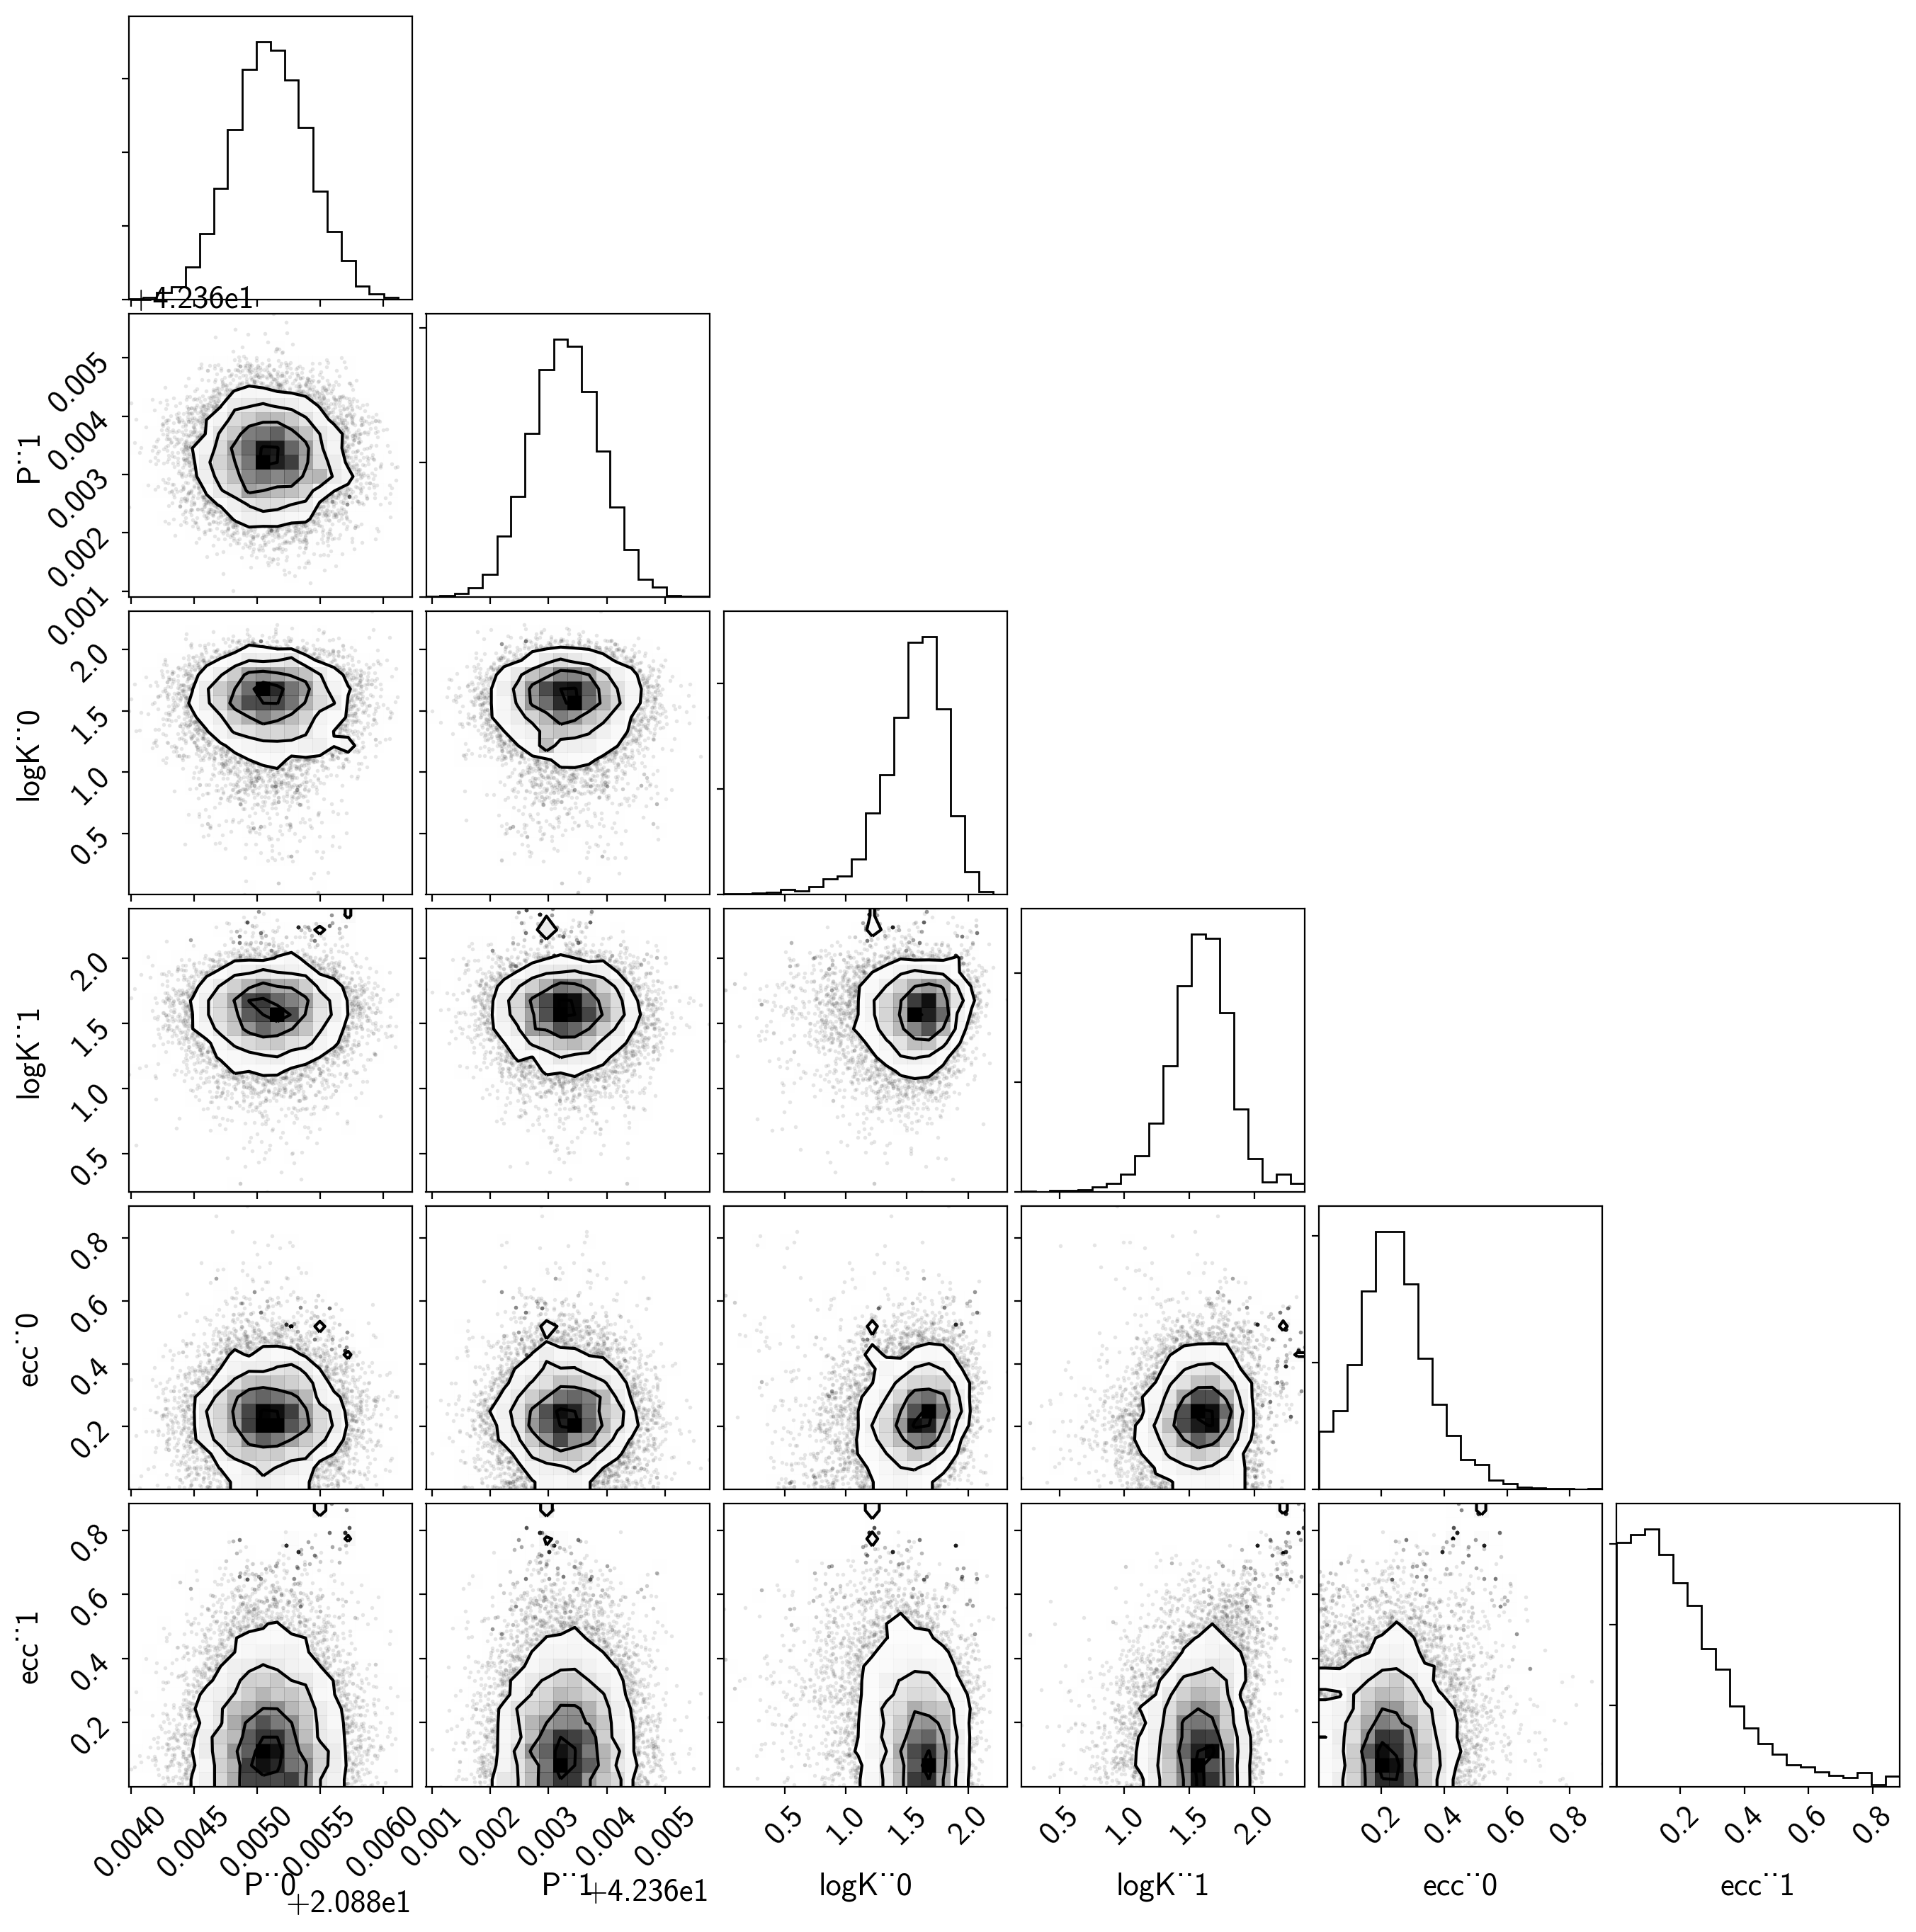

In [13]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["P", "logK", "ecc"])
corner.corner(samples);

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

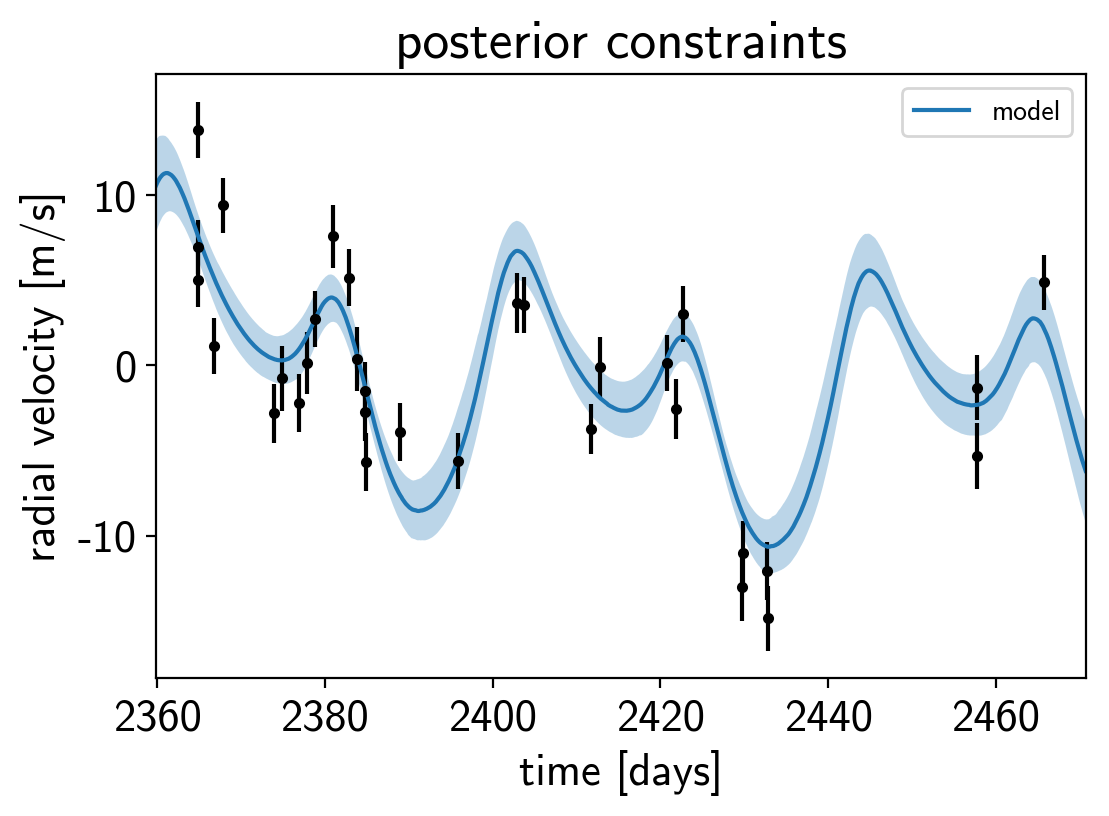

In [14]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("posterior constraints");

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

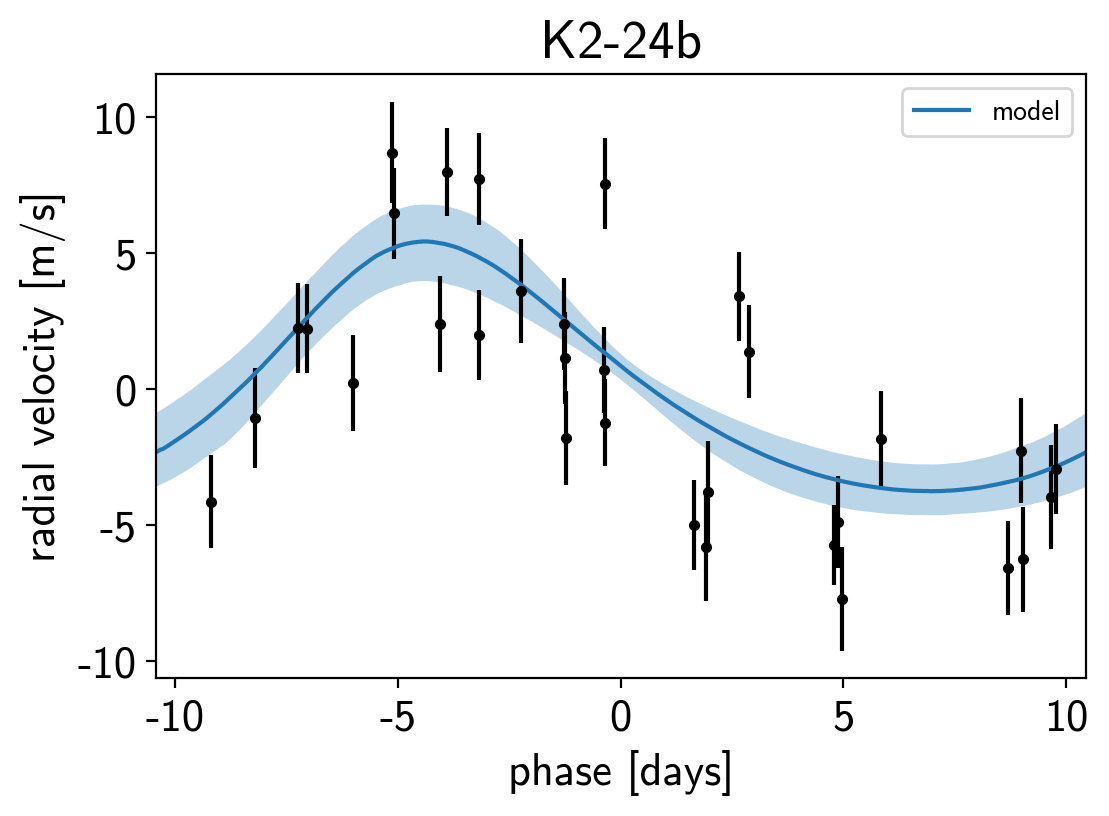

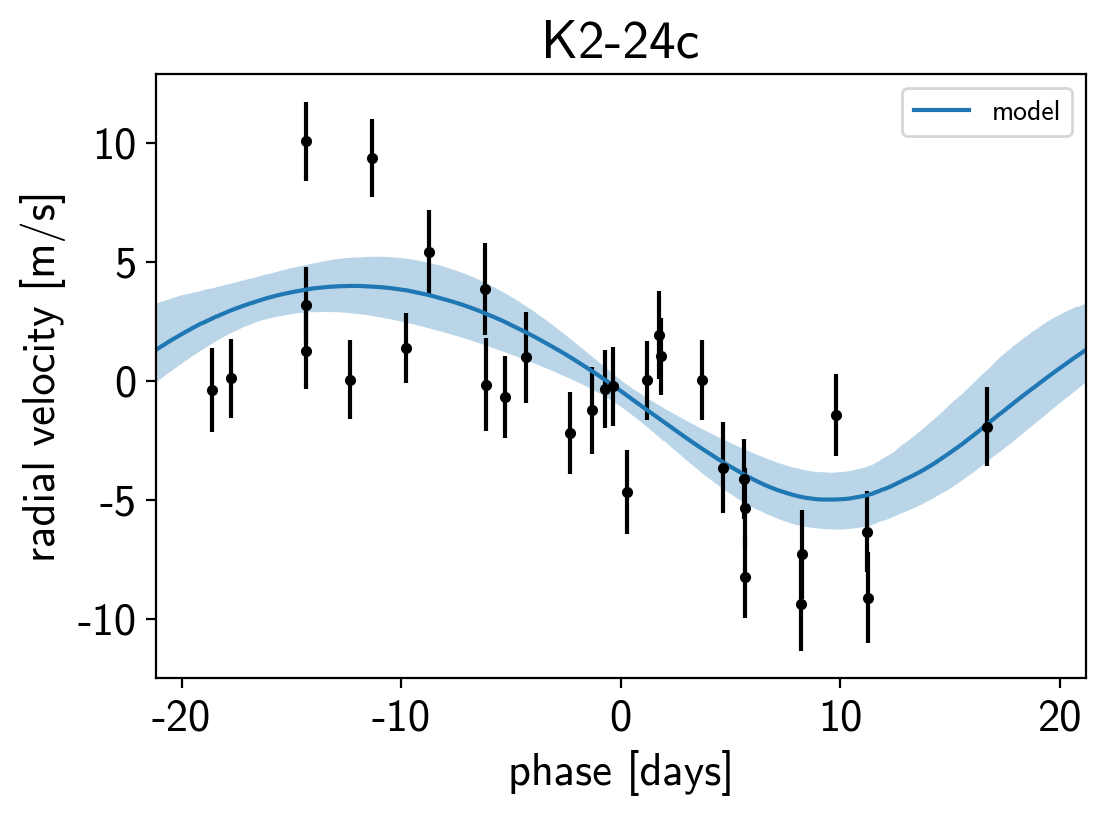

In [15]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["P"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));